In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
np.set_printoptions(threshold=np.inf)
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# from sklearn.metrics import mean_squared_error

In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [0]:
# latest cases
cases = pd.read_csv('time_series_covid19_confirmed_global.csv')
cases = cases.drop(columns = ['Province/State','Lat','Long'])
country_cases = cases.groupby(['Country/Region'],as_index=False).agg('sum')

# Model for single country

In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
cases = country_cases.loc[country_cases['Country/Region'] == 'United Kingdom'] 
cases = cases.drop(columns = ['Country/Region'])
cases = cases.astype('float64')
dataset = cases.to_numpy()[0]

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset[:, np.newaxis])

In [0]:
test_data_size = 10
train = dataset[:-test_data_size]
test = dataset[-test_data_size:]

In [0]:
# variant loss fuctions
from keras.losses import mean_squared_error, mean_absolute_error, huber_loss, logcosh

loss_dict = {'mse': mean_squared_error,
             'mae': mean_absolute_error, 
             'huber_loss': huber_loss,
             'logcosh': logcosh
             }
'''
  choose loss function: 
    mse, mae, huber, logcosh 
  optimizer: 
    adam, sgd, adadelta, adagrad, rmsprop
'''
loss_l = ['mse']
opt_l = ['adam']

class LOMS:
  # loss func name
  loss_name = ''
  # optimizer name
  opt_name = ''
  # model list
  models = []
  # score list
  scores = []
  # trainPredict list
  trainPredict = []
  # testPredict list
  testPredict = []

  def __init__(self, loss_name, opt_name, models, scores):
    self.loss_name = loss_name
    self.opt_name = opt_name
    self.models = models
    self.scores = scores

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


epochs = 100
batch_size = 1
loms_l = []

for i, lname in enumerate(loss_l):
  temp_l = []
  for j, oname in enumerate(opt_l):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    # loss name, optimizer name
    model.compile(loss=lname, optimizer=oname)

    scores = [0] * epochs
    models = [0] * epochs

    # record models and evaluate scores
    for k in range(epochs):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2)
      models[k] = model
      scores[k] = model.evaluate(testX, testY, batch_size=batch_size)
    #  add to list
    temp_l.append(LOMS(lname, oname, models, scores))
  loms_l.append(temp_l)

In [0]:
import matplotlib.pyplot as plt

for i in range(len(opt_l)):
  for j in range(len(loss_l)):
    plt.plot(loms_l[j][i].scores, label=loms_l[j][i].loss_name)
  plt.xlabel('number of epochs')
  plt.ylabel('test loss')
  plt.title('loss ' + loms_l[j][i].opt_name + ' optimizer', fontsize='large')
  plt.legend(fontsize=20)
  plt.show()

In [0]:
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [0]:
'''
  store trainPredict list, testPredict list wrt model 
  find the optimal model with least error wrt different optimizers.
'''

for i in range(len(loss_l)):
  for j in range(len(opt_l)):
    model = loms_l[i][j].models[-1]
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)

    loms_l[i][j].trainPredict = trainPredict
    loms_l[i][j].testPredict = testPredict

    # loss name 
    ln = loms_l[i][j].loss_name

    # calculate root of ...
    # trainScore = loms_l[i][j].trainScore
    # print('Train Score: ', trainScore, ln, loms_l[i][j].opt_name )
    testScore = round(loms_l[i][j].scores[-1],4)
    print('Test Score:  ', testScore,'\t', ln, '\t', loms_l[i][j].opt_name )

In [0]:
def plotTT(dataset, trainPredict, testPredict, lossname, optname):
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.title('Latest Confirmed cases predict for UK ' + lossname + ' ' + optname, fontsize=24) 
  plt.plot(scaler.inverse_transform(dataset), label='true plot')
  plt.plot(trainPredictPlot, label='train predict')
  plt.plot(testPredictPlot, label='test predict')
  plt.legend(fontsize='large')
  plt.show()

'''
  Select above with n loss func and optimizers wrt error close to zero
'''

for i in range(len(loss_l)):
  for j in range(len(opt_l)):
    if loms_l[i][j].loss_name == 'mse' and loms_l[i][j].opt_name == 'adam':
      plotTT(dataset, loms_l[i][j].trainPredict, loms_l[i][j].testPredict, loms_l[i][j].loss_name, loms_l[i][j].opt_name)
    if loms_l[i][j].loss_name == 'mse' and loms_l[i][j].opt_name == 'adadelta':
      plotTT(dataset, loms_l[i][j].trainPredict, loms_l[i][j].testPredict, loms_l[i][j].loss_name, loms_l[i][j].opt_name)
    if loms_l[i][j].loss_name == 'mse' and loms_l[i][j].opt_name == 'rmsprop':
      plotTT(dataset, loms_l[i][j].trainPredict, loms_l[i][j].testPredict, loms_l[i][j].loss_name, loms_l[i][j].opt_name)
    if loms_l[i][j].loss_name == 'hinge' and loms_l[i][j].opt_name == 'adam':
      plotTT(dataset, loms_l[i][j].trainPredict, loms_l[i][j].testPredict, loms_l[i][j].loss_name, loms_l[i][j].opt_name)
    if loms_l[i][j].loss_name == 'hinge' and loms_l[i][j].opt_name == 'rmsprop':
      plotTT(dataset, loms_l[i][j].trainPredict, loms_l[i][j].testPredict, loms_l[i][j].loss_name, loms_l[i][j].opt_name)
    

# for global

## normalize the data by considering population density

In [0]:
population_density = pd.read_csv('population_density.csv')
population_density['Density'] = population_density['Density'].str.replace(',','').astype(float)
country_cases_density = country_cases.set_index('Country/Region').join(population_density.set_index('Country (or dependent territory)'))

# filter out some countryies that don't have many cases
filter1 = country_cases_density.iloc[:,-2]>1000
country_cases_density.where(filter1, inplace = True)
country_cases_density = country_cases_density.dropna(how = 'all')
country_cases_density_backup = country_cases_density
# country_cases_density = country_cases_density.drop(['Russia','Czechia'])
country_cases_density.dropna(subset = ["Density"], inplace=True)

# country_cases_density.iloc[0,50]
for i in range(country_cases_density.shape[1]-1):
    country_cases_density.iloc[:,i] = country_cases_density.iloc[:,i]/country_cases_density.iloc[:,-1]

country_density_without_dcolumn = country_cases_density.drop(columns = ['Density'])
# store index of country
countryMap = {}
length = len(country_density_without_dcolumn.index)
for i in range(length):
    countryMap[country_density_without_dcolumn.index[i]] = i

## train model

In [0]:
global_dataset = country_density_without_dcolumn.to_numpy() # convert dataframe to numpy

In [0]:
def create_dataset_global(dataset, look_back=1):
    dataX, dataY = [], []
    for j in range(dataset.shape[0]):
        for i in range(dataset.shape[1]-look_back-1):
            a = dataset[j,i:(i+look_back)]
            if a.any():
                dataX.append(a)
                dataY.append(dataset[j,i + look_back])
    return np.array(dataX), np.array(dataY)

In [0]:
scaler_global = MinMaxScaler(feature_range=(0,1))
global_dataset_scale = scaler_global.fit_transform(global_dataset.flatten()[:, np.newaxis])
global_dataset_scale = np.reshape(global_dataset_scale,(global_dataset.shape[0],global_dataset.shape[1]))

In [0]:
# variant loss fuctions
from keras.losses import mean_squared_error, mean_absolute_error, huber_loss, logcosh

loss_dict = {'mse': mean_squared_error,
             'mae': mean_absolute_error, 
             'huber_loss': huber_loss,
             'logcosh': logcosh
             }
'''
  choose loss function: 
    mse, mae, huber, logcosh 
  optimizer: 
    adam, sgd, adadelta, adagrad, rmsprop
'''
loss_l = ['huber_loss', 'logcosh', 'mse','mae']
opt_l = ['adam', 'sgd', 'adadelta', 'adagrad', 'rmsprop']

class LOMS:
  # loss func name
  loss_name = ''
  # optimizer name
  opt_name = ''
  # model list
  models = []
  # score list
  scores = []
  # trainPredict list
  trainPredict = []
  # testPredict list
  testPredict = []

  def __init__(self, loss_name, opt_name, models, scores):
    self.loss_name = loss_name
    self.opt_name = opt_name
    self.models = models
    self.scores = scores

In [0]:
test_data_size = 10
train = global_dataset_scale[:,:-test_data_size]
test = global_dataset_scale[:,-test_data_size:]

# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset_global(train, look_back)
testX, testY = create_dataset_global(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
epochs = 10
batch_size = 1
loms_l = []

for i, oname in enumerate(opt_l):
  temp_l = []
  for j, lname in enumerate(loss_l):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    # loss name, optimizer name
    model.compile(loss=lname, optimizer=oname)

    scores = [0] * epochs
    models = [0] * epochs

    # record models and evaluate scores
    for k in range(epochs):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2)
      models[k] = model
      scores[k] = model.evaluate(testX, testY, batch_size=batch_size)
    #  add to list
    temp_l.append(LOMS(lname, oname, models, scores))
  loms_l.append(temp_l)

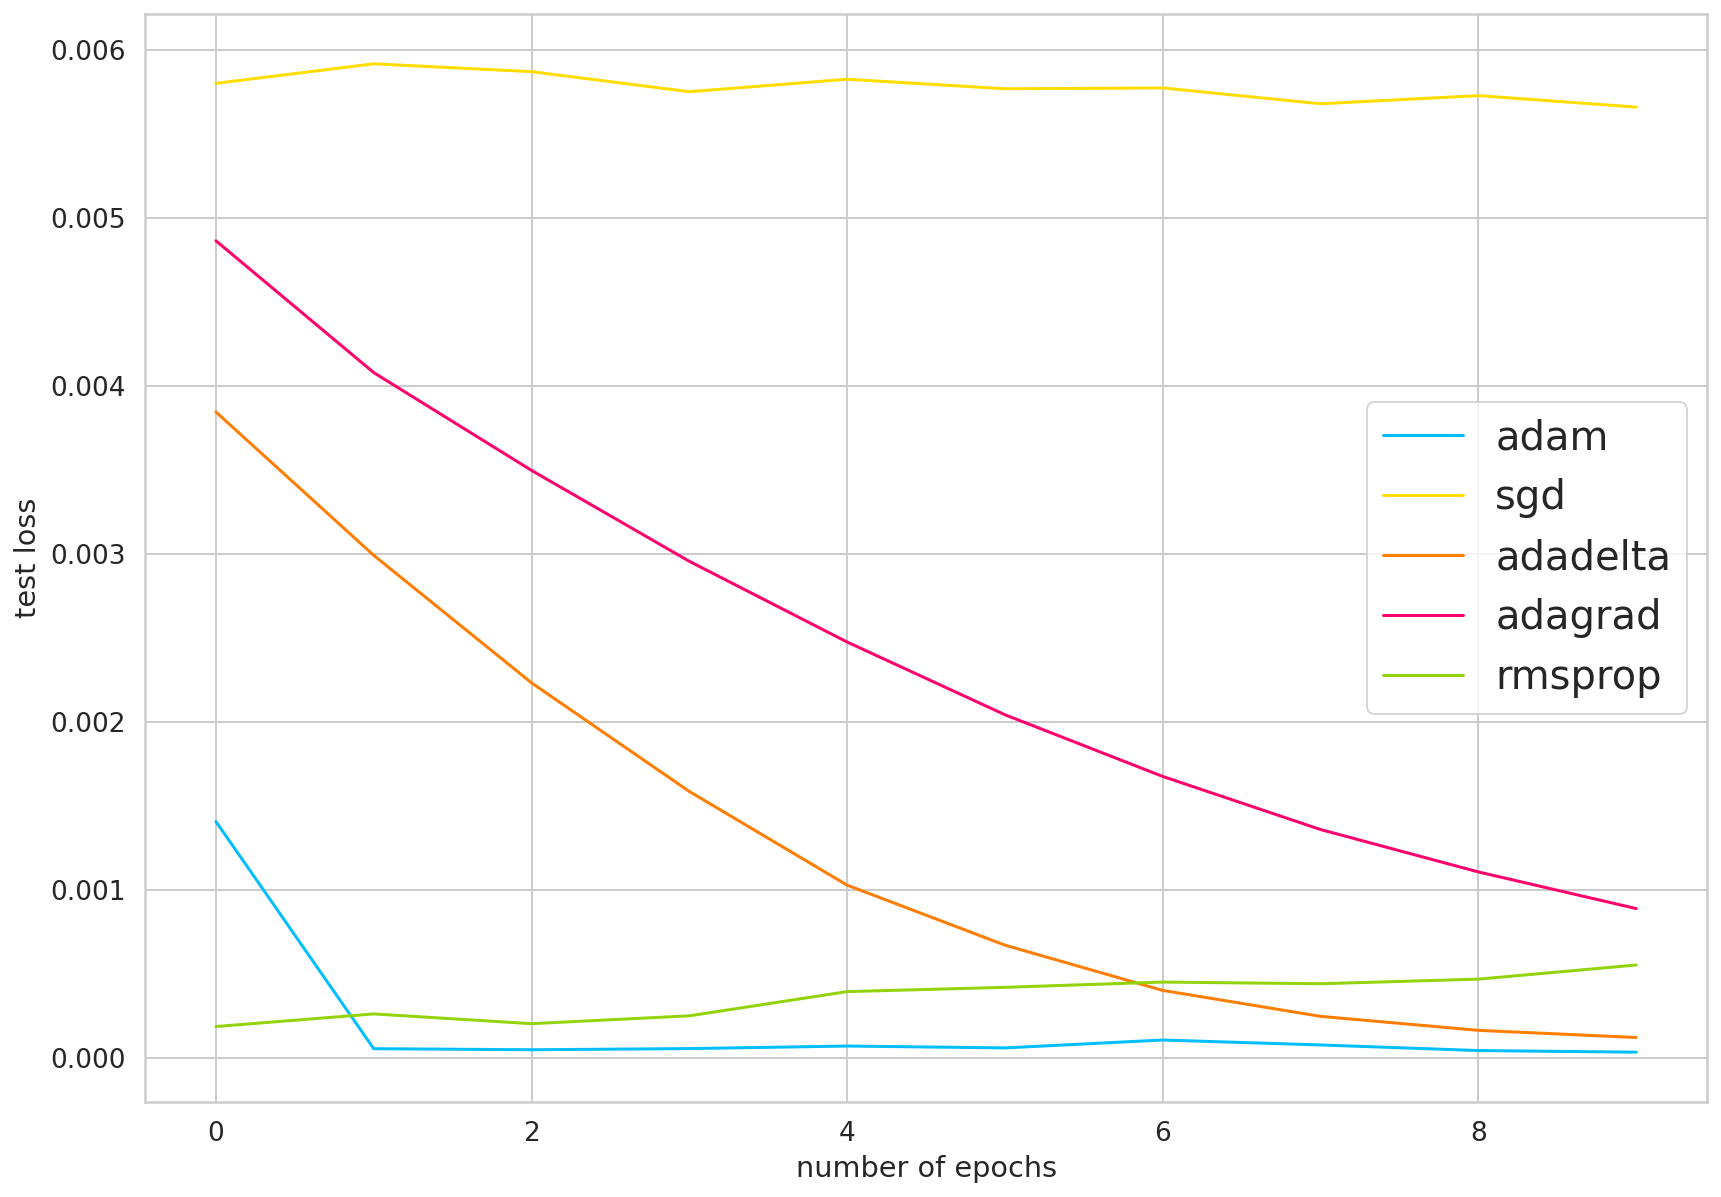

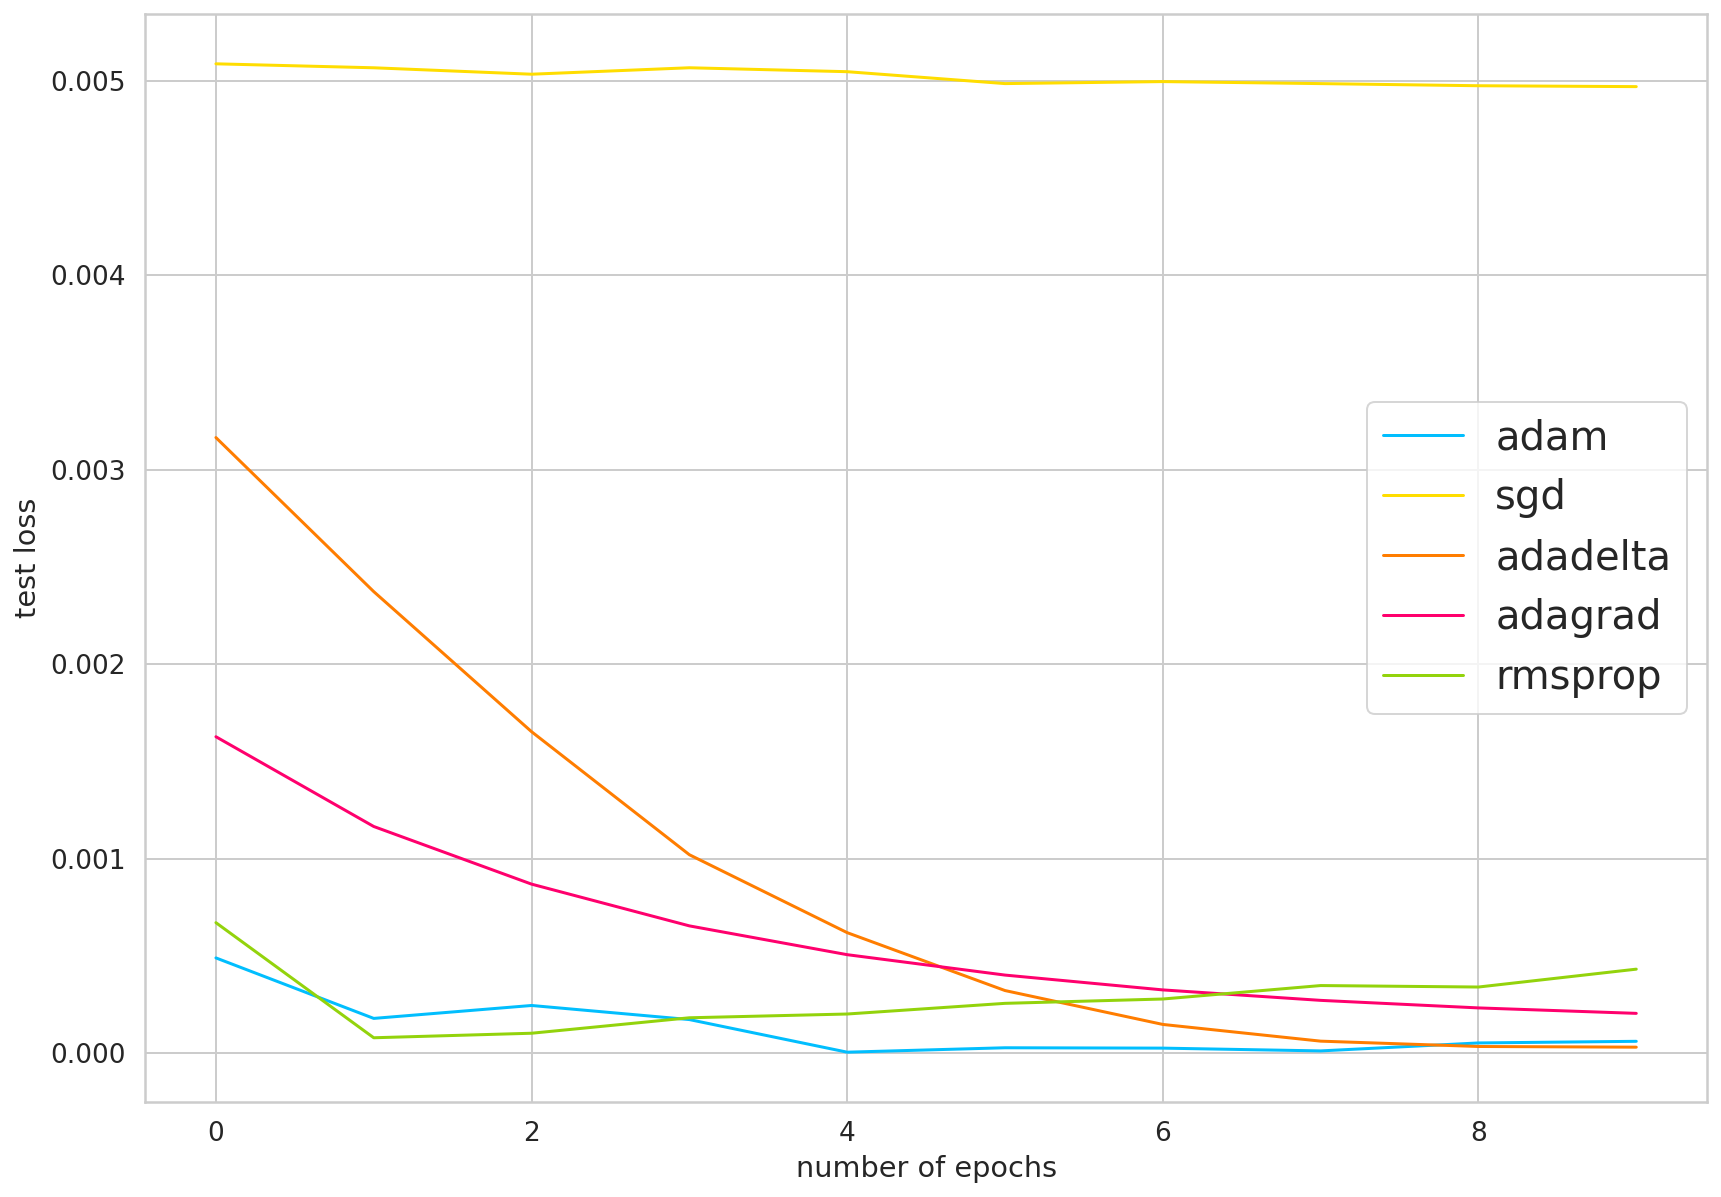

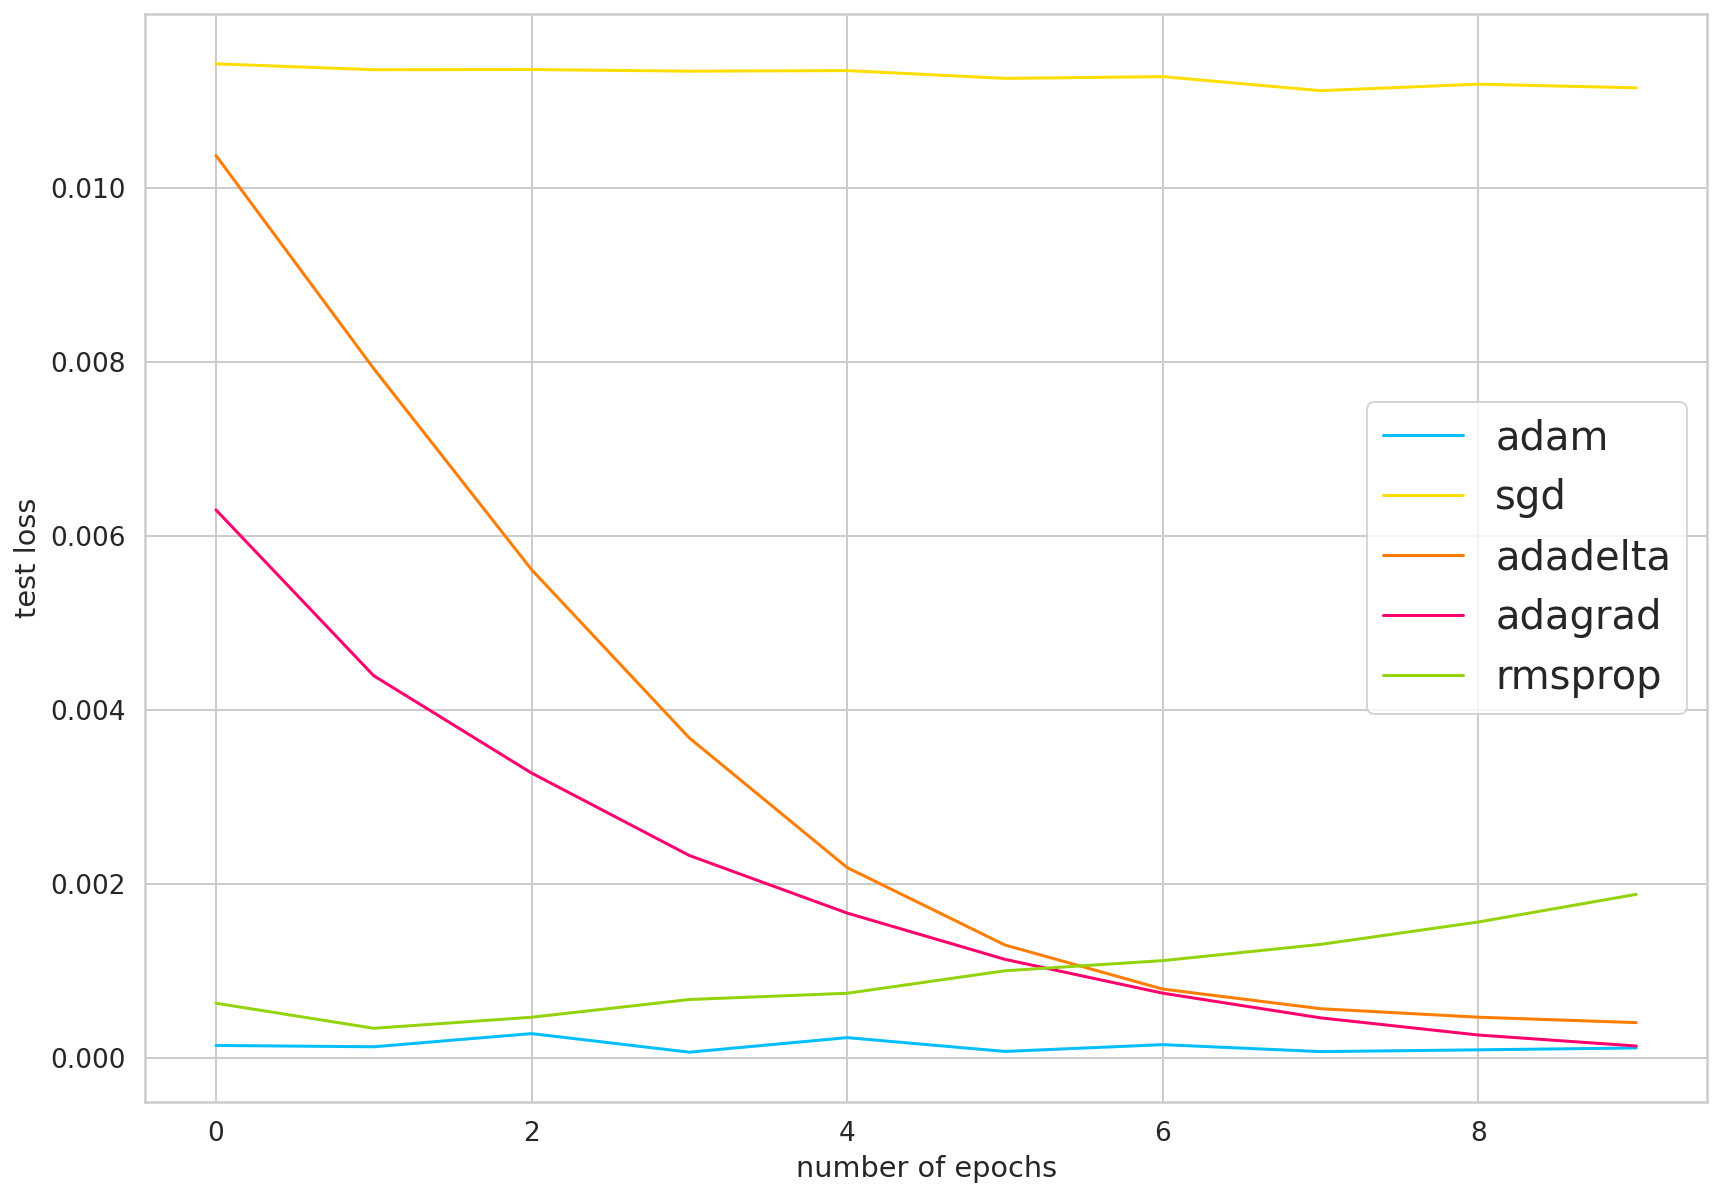

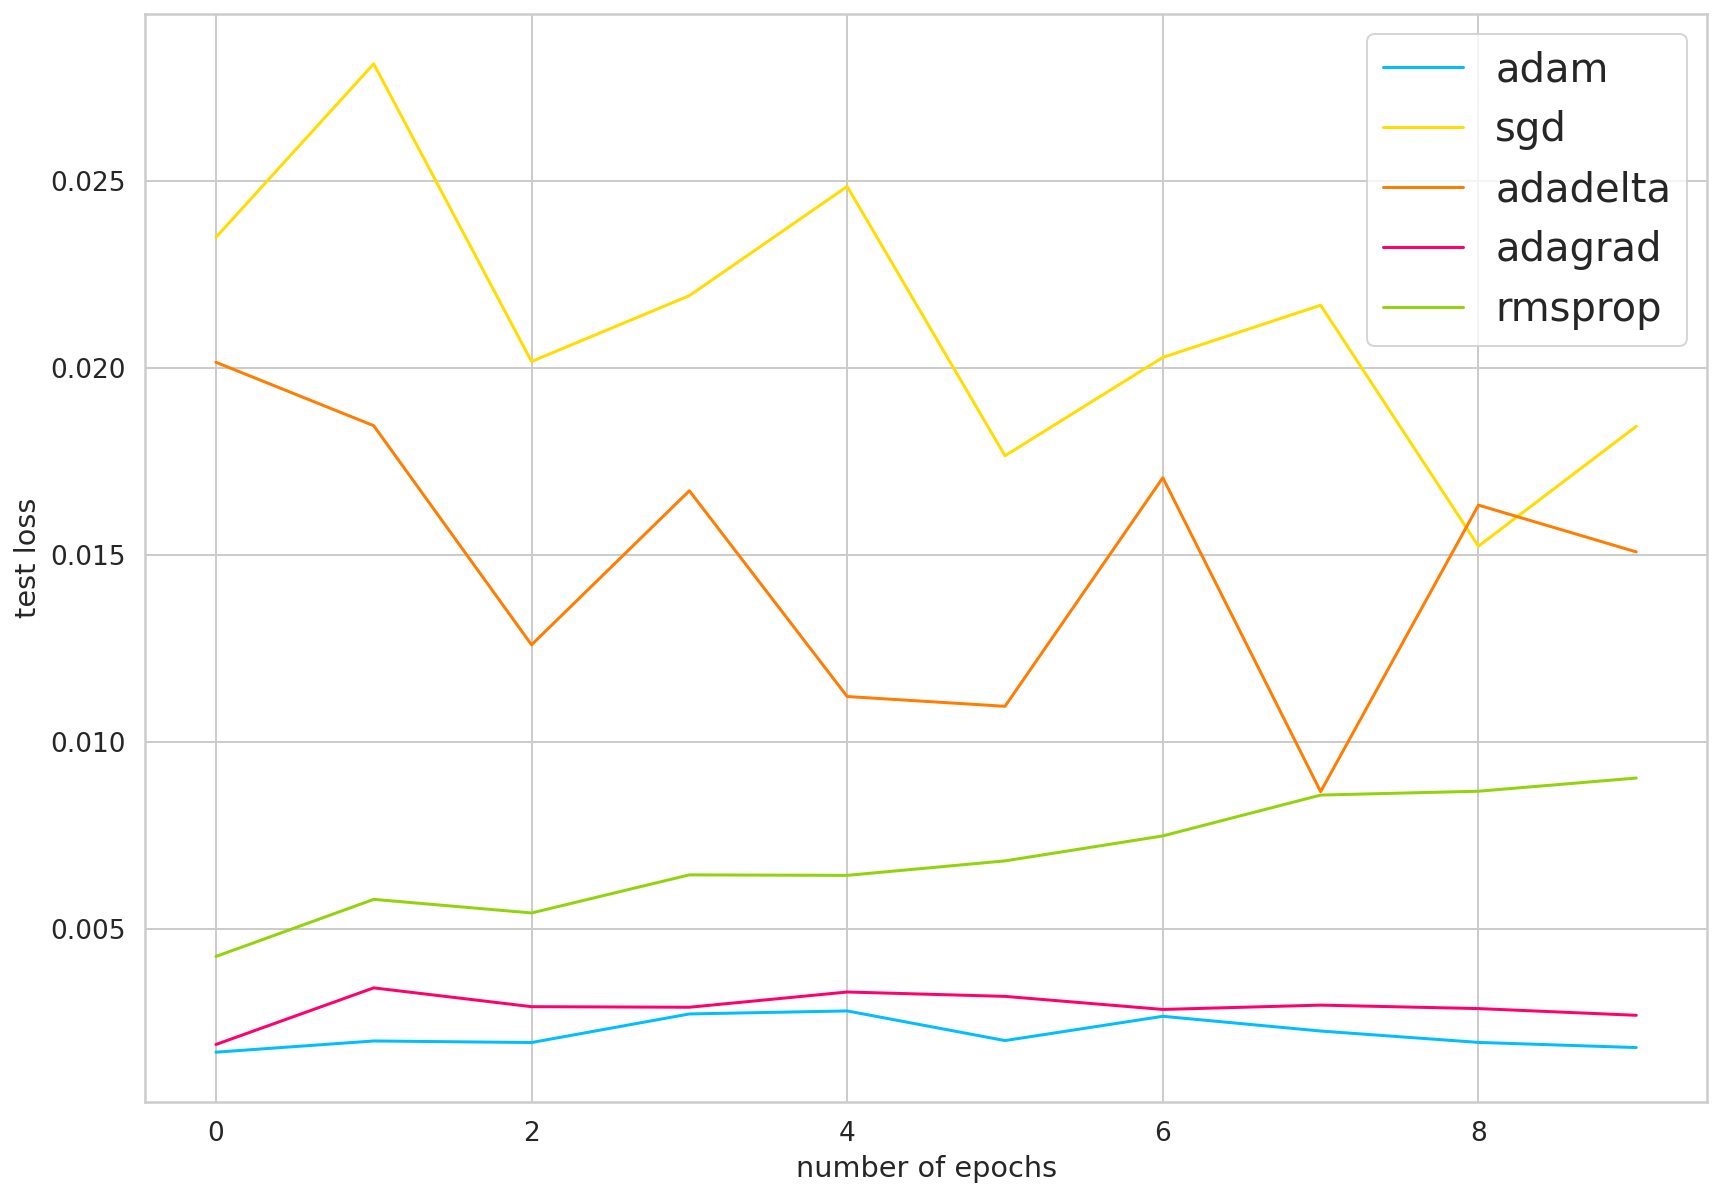

In [0]:
import matplotlib.pyplot as plt

for i in range(len(loss_l)):
  for j in range(len(opt_l)):
    plt.plot(loms_l[j][i].scores, label=loms_l[j][i].opt_name)
  plt.xlabel('number of epochs')
  plt.ylabel('test loss')
  plt.title(loms_l[j][i].loss_name + ' loss ', fontsize='large')
  plt.legend(fontsize=20)
  plt.show()

## test model with single country

In [0]:
def testModelSingleCountry(countryName, model):
    train = global_dataset_scale[countryMap[countryName],:-test_data_size]
    test = global_dataset_scale[countryMap[countryName],-test_data_size-look_back:]
    train = np.reshape(train, (len(train),1))
    test = np.reshape(test, (len(test),1))
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY= create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler_global.inverse_transform(trainPredict)
    trainY = scaler_global.inverse_transform([trainY])
    testPredict = scaler_global.inverse_transform(testPredict)
    testY = scaler_global.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    return trainScore, testScore, trainPredict, testPredict

In [0]:
def plot(countryName,trainPredict,testPredict, opt_name):
    cases = country_cases.loc[country_cases['Country/Region'] == countryName] 
    cases = cases.drop(columns = ['Country/Region'])
    cases = cases.astype('float64')
    dataset = cases.to_numpy()[0]
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset[:, np.newaxis])
    # # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1-look_back:len(dataset)-1, :] = testPredict
    # plot predictions
    # plt.plot(scaler_global.inverse_transform([global_dataset_scale[countryMap[countryName]]])[0])
    plt.plot(trainPredictPlot, label='train ' + opt_name)
    plt.plot(testPredictPlot, label='test ' + opt_name)
    # plt.show()

Train Score: 169.04 RMSE adam
Test Score: 591.9 RMSE adam
Train Score: 150.74 RMSE adadelta
Test Score: 2273.96 RMSE adadelta
Train Score: 553.62 RMSE adagrad
Test Score: 1653.51 RMSE adagrad
Train Score: 420.29 RMSE rmsprop
Test Score: 5331.51 RMSE rmsprop


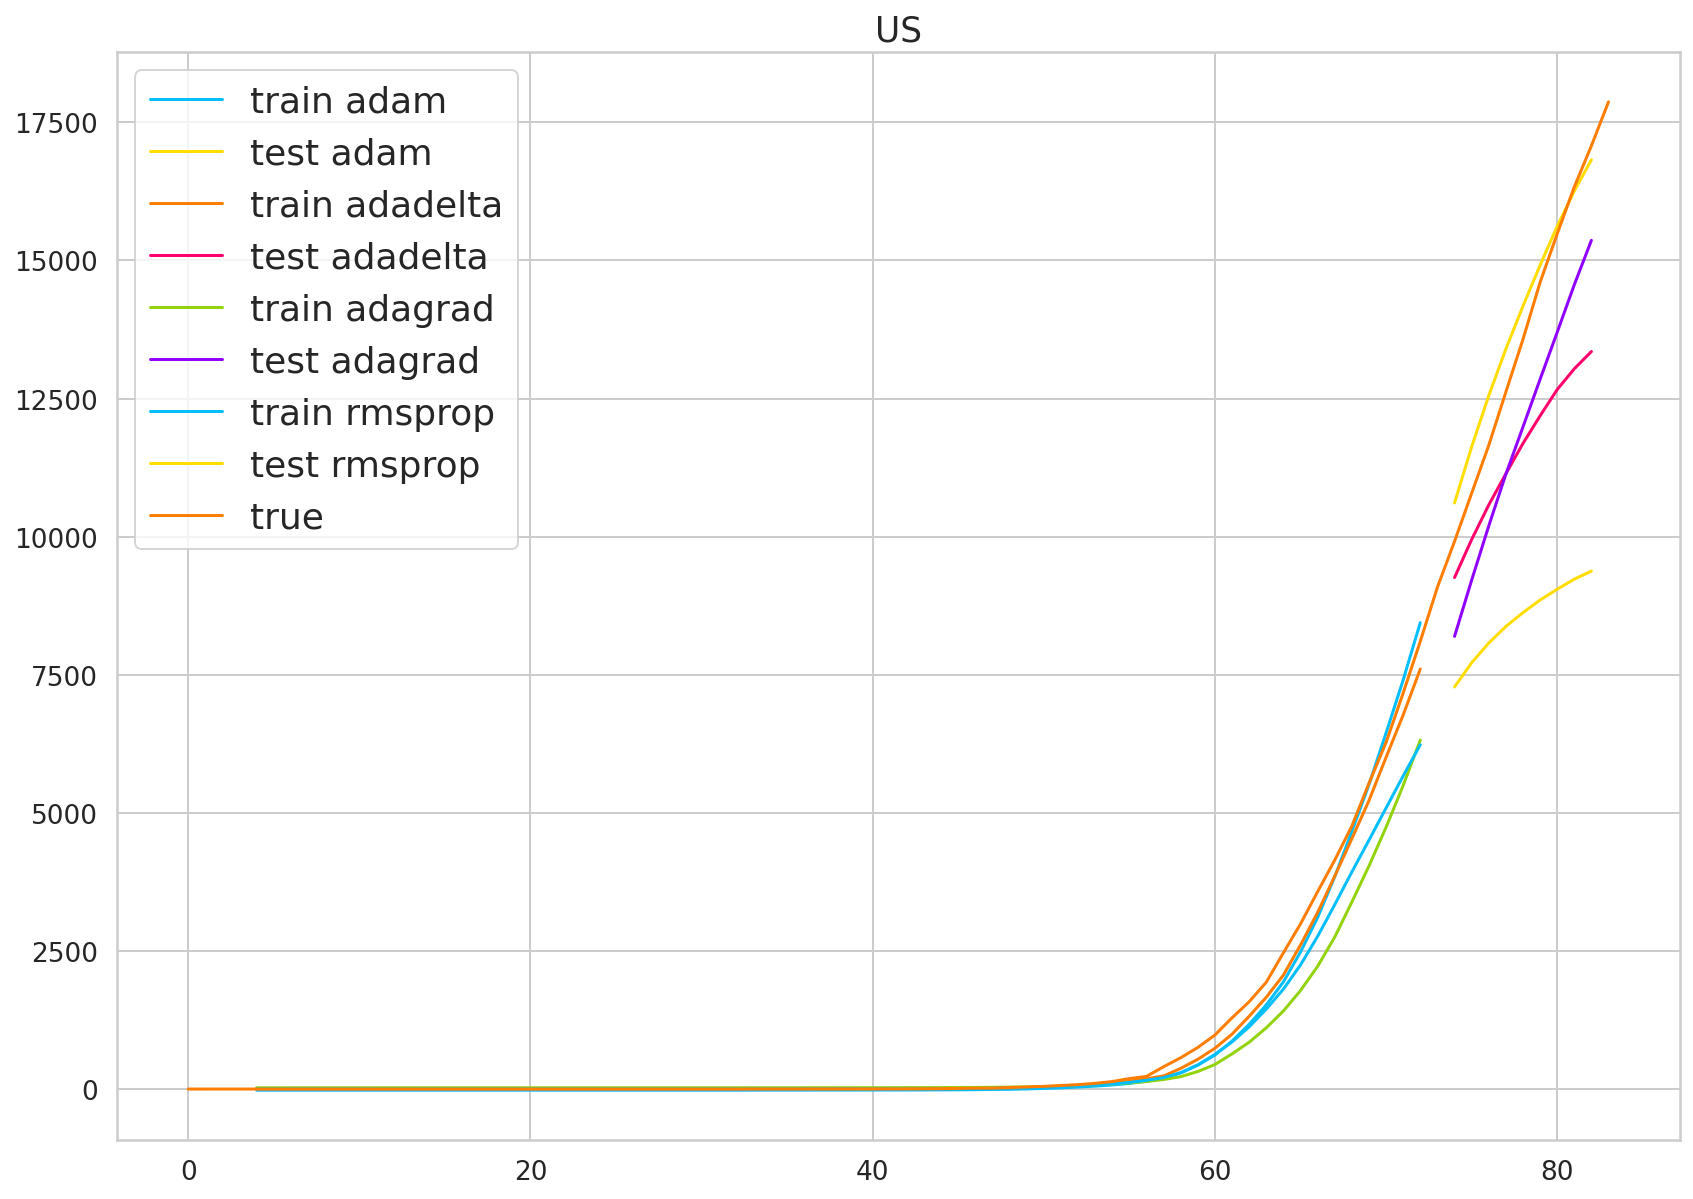

Train Score: 29.63 RMSE adam
Test Score: 129.35 RMSE adam
Train Score: 27.46 RMSE adadelta
Test Score: 141.43 RMSE adadelta
Train Score: 25.48 RMSE adagrad
Test Score: 13.27 RMSE adagrad
Train Score: 16.73 RMSE rmsprop
Test Score: 94.64 RMSE rmsprop


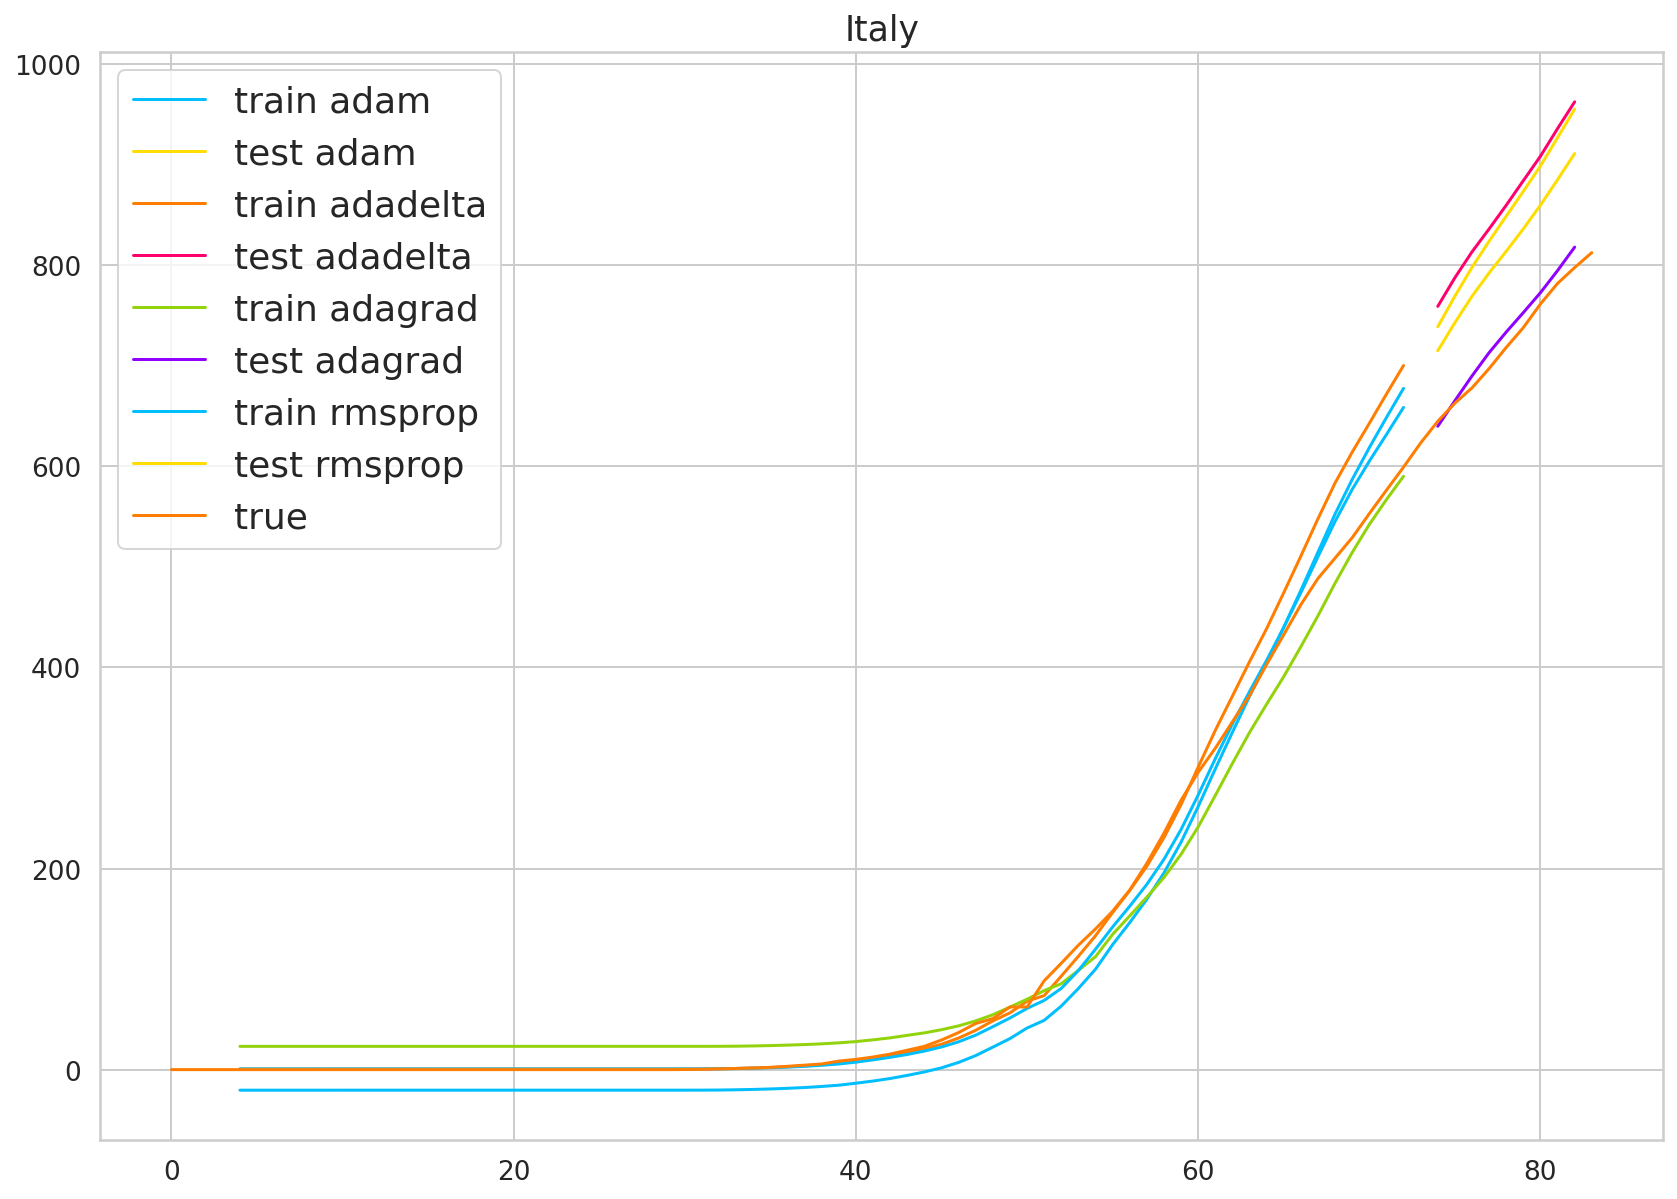

Train Score: 42.95 RMSE adam
Test Score: 364.54 RMSE adam
Train Score: 29.25 RMSE adadelta
Test Score: 298.17 RMSE adadelta
Train Score: 75.28 RMSE adagrad
Test Score: 44.66 RMSE adagrad
Train Score: 31.23 RMSE rmsprop
Test Score: 189.26 RMSE rmsprop


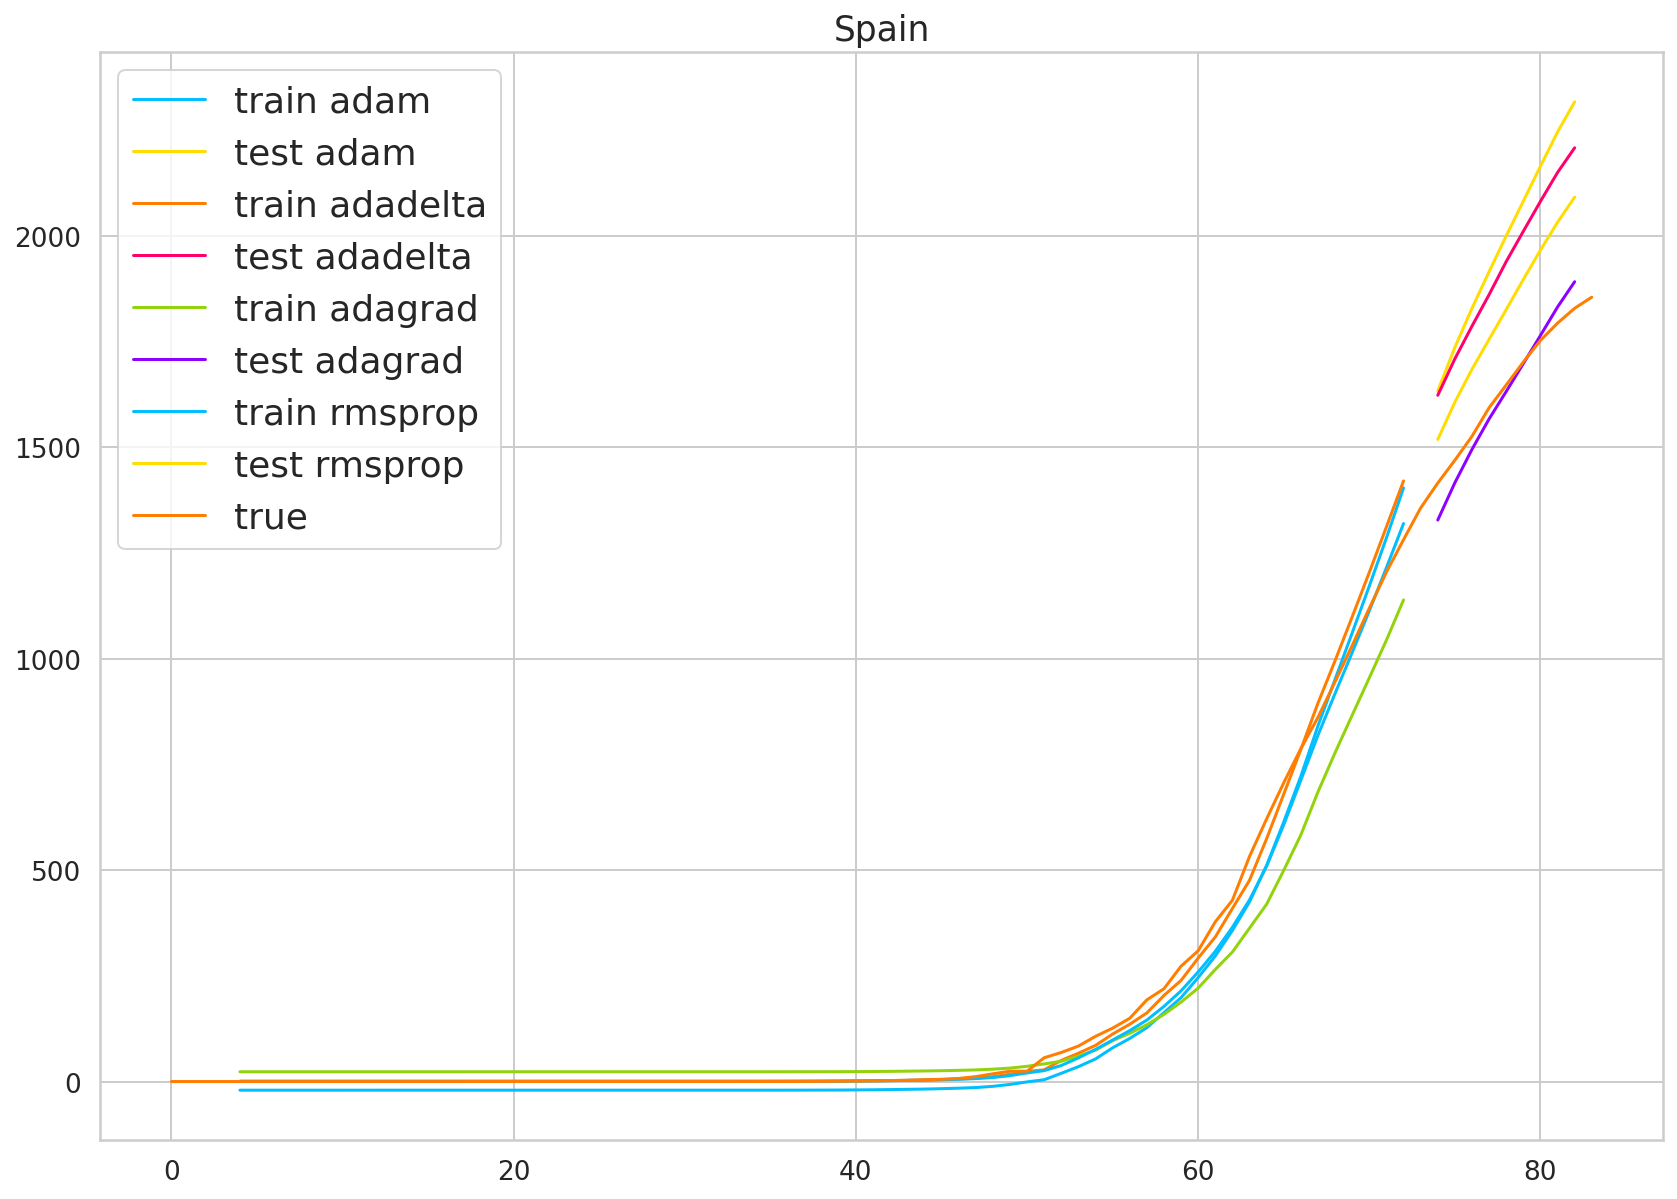

Train Score: 24.52 RMSE adam
Test Score: 67.62 RMSE adam
Train Score: 8.78 RMSE adadelta
Test Score: 90.32 RMSE adadelta
Train Score: 24.02 RMSE adagrad
Test Score: 12.54 RMSE adagrad
Train Score: 8.88 RMSE rmsprop
Test Score: 56.63 RMSE rmsprop


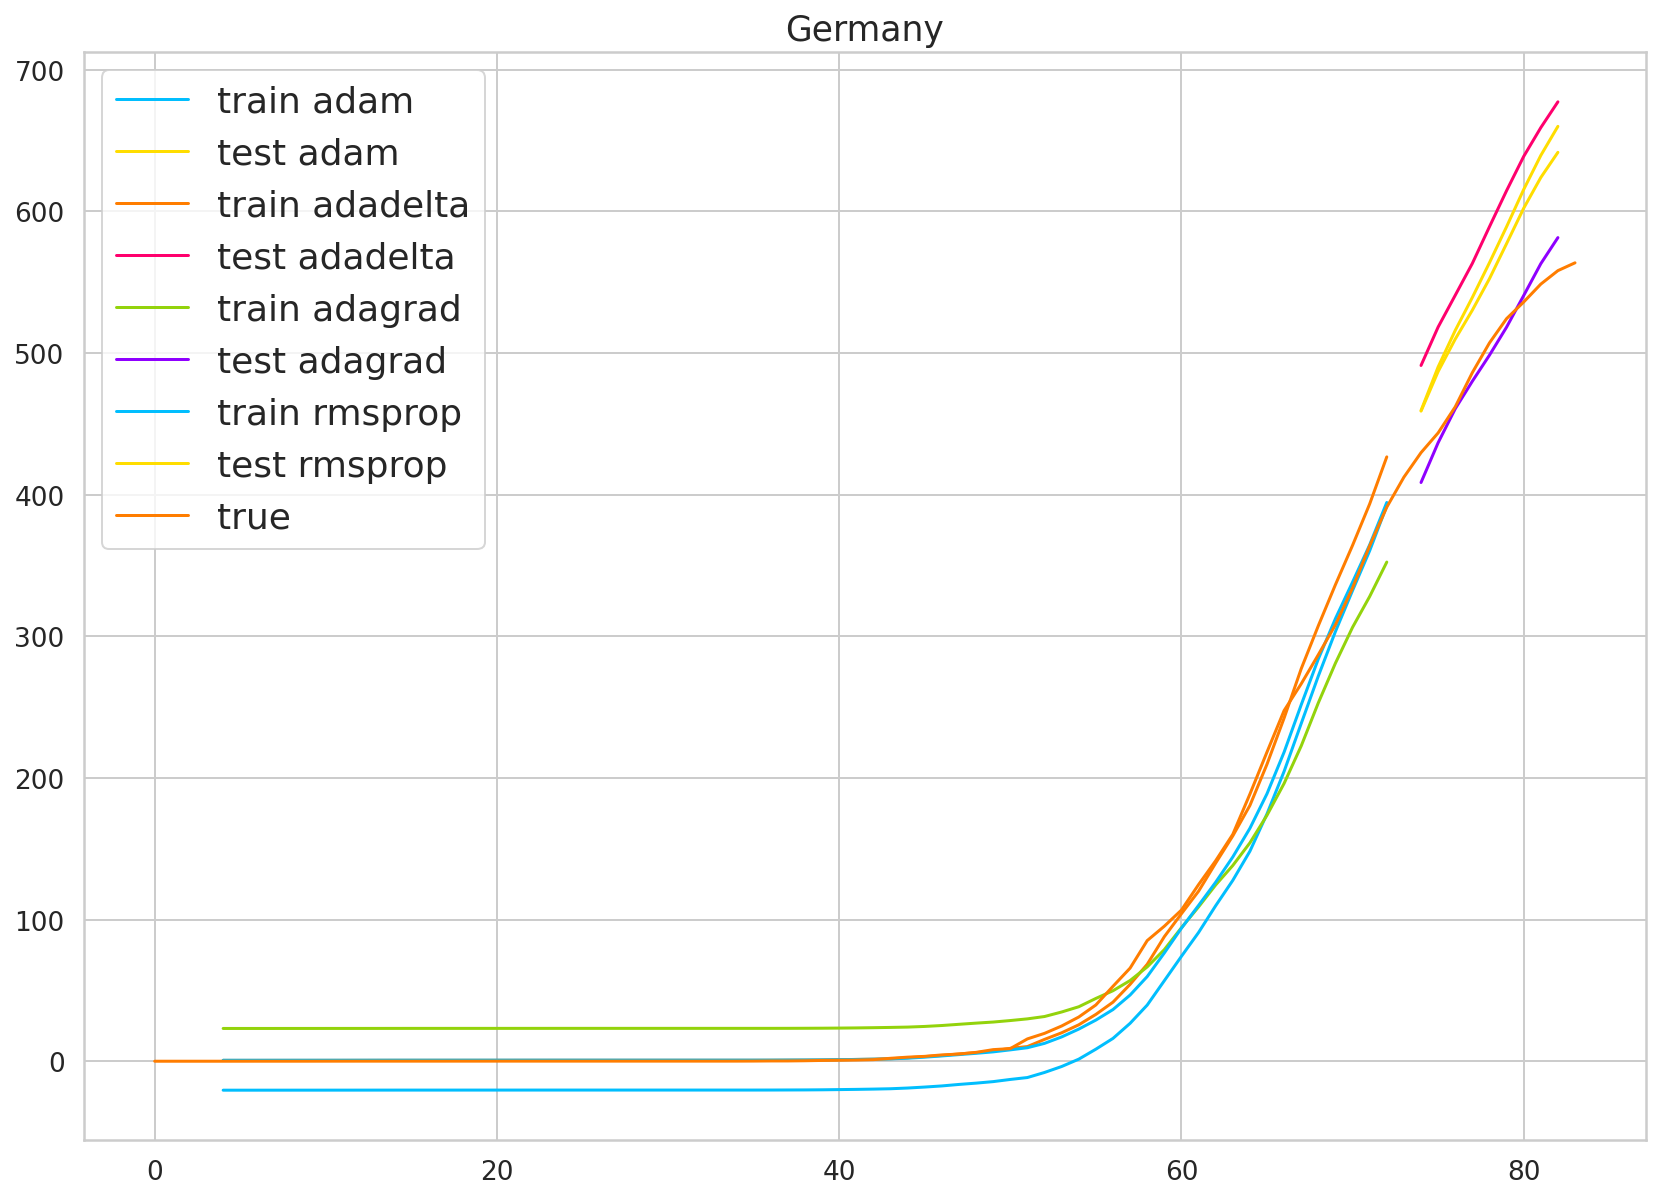

Train Score: 110.72 RMSE adam
Test Score: 142.41 RMSE adam
Train Score: 117.08 RMSE adadelta
Test Score: 149.33 RMSE adadelta
Train Score: 52.76 RMSE adagrad
Test Score: 62.45 RMSE adagrad
Train Score: 91.34 RMSE rmsprop
Test Score: 117.01 RMSE rmsprop


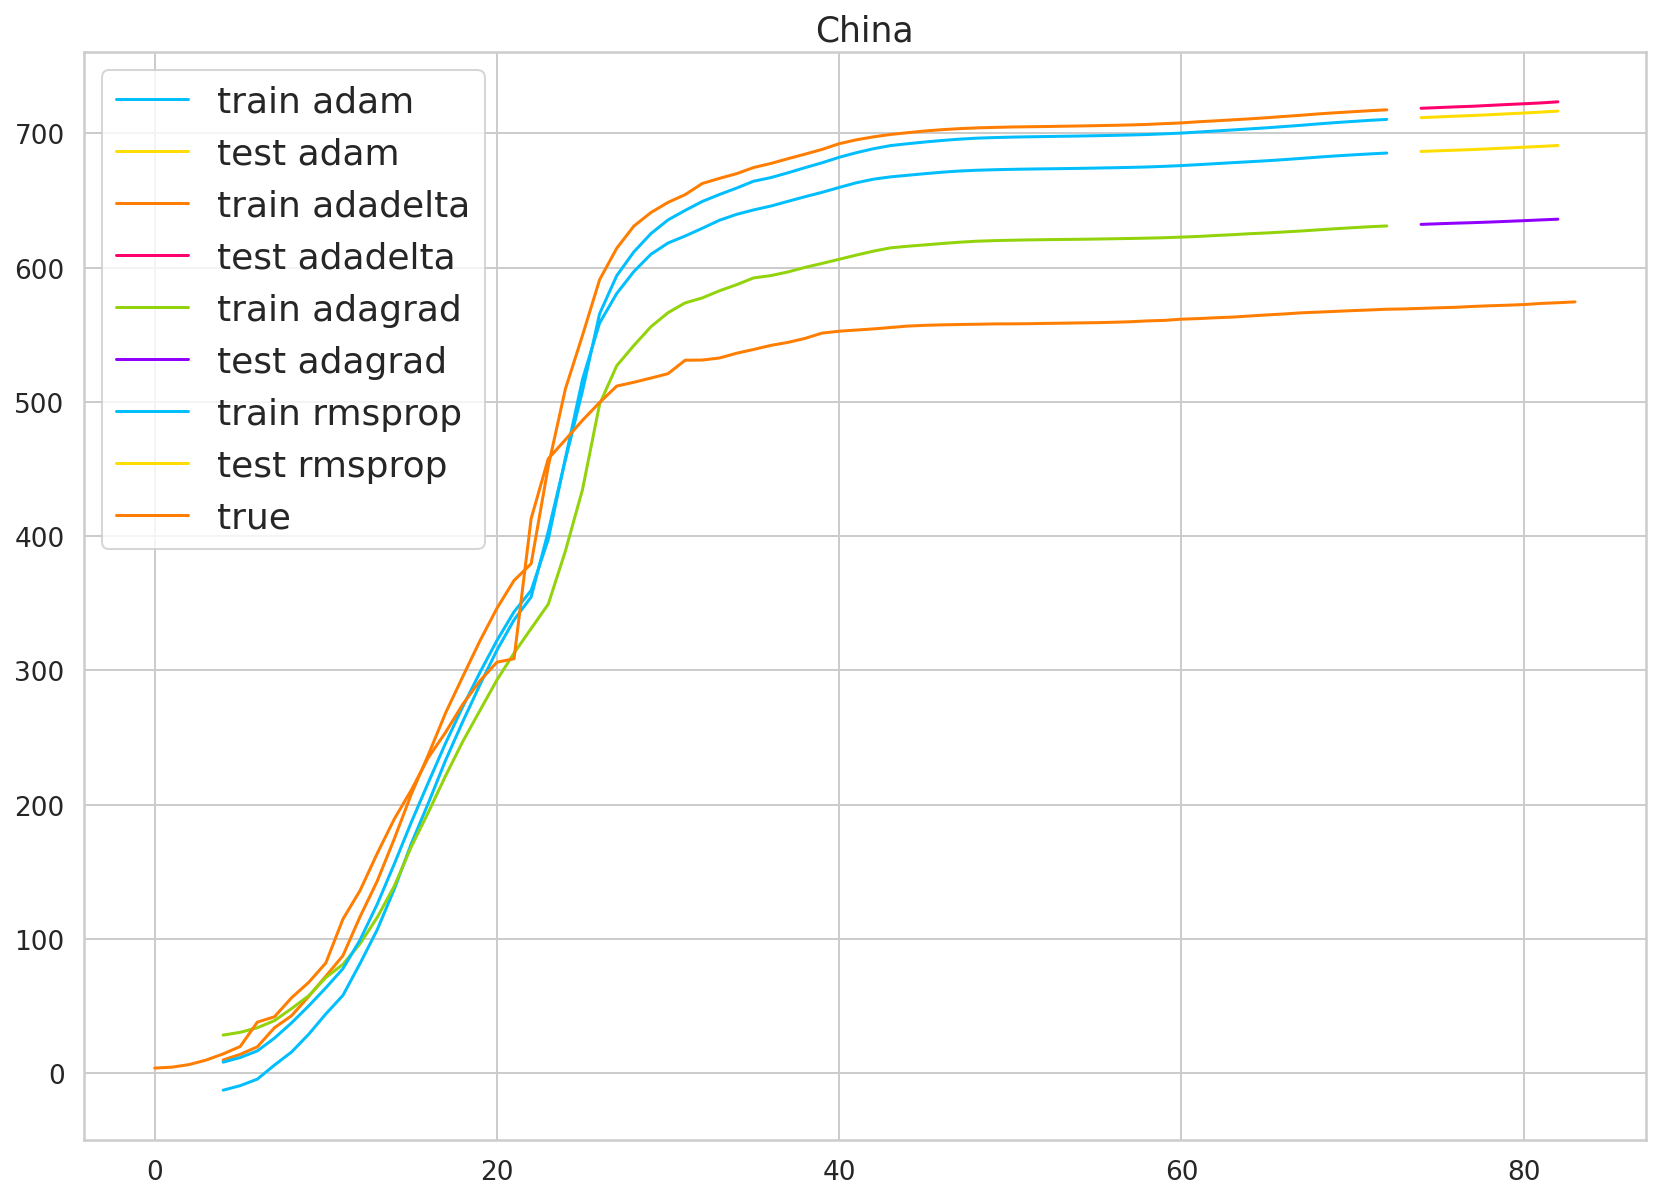

In [0]:
'''
  As the above mse is the optimal loss function, adam,adadelta,adagrad,rmsprop is similar convergence.
'''
# top 5 country
countries_l = ['US', 'Italy', 'Spain', 'Germany', 'China']
loms_sel = []
for i in range(len(opt_l)):
  for j in range(len(loss_l)):
    loms_obj = loms_l[i][j]
    if \
    loms_obj.loss_name == 'mse' and loms_obj.opt_name == 'adam' or \
    loms_obj.loss_name == 'mse' and loms_obj.opt_name == 'adadelta' or \
    loms_obj.loss_name == 'mse' and loms_obj.opt_name == 'adagrad' or \
    loms_obj.loss_name == 'mse' and loms_obj.opt_name == 'rmsprop':
      loms_sel.append(loms_obj)


for country in countries_l:
  for loms in loms_sel:
    trainScore, testScore, trainPredict, testPredict = testModelSingleCountry(country, loms.models[-1])
    # plot 
    plot(country, trainPredict, testPredict, loms.opt_name)

    # calculate root mean squared error
    print('Train Score:', round(trainScore, 2), 'RMSE', loms.opt_name)
    print('Test Score:', round(testScore, 2), 'RMSE', loms.opt_name)

  # plot baseline
  plt.plot(scaler_global.inverse_transform([global_dataset_scale[countryMap[country]]])[0], label='true')
  plt.title(country, fontsize='large')
  plt.legend(fontsize=18)
  plt.show()